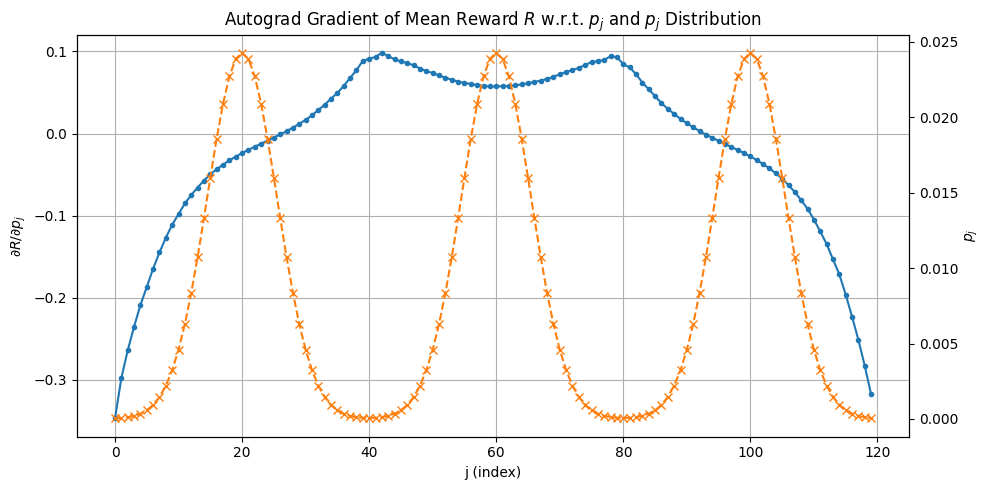

In [2]:
import torch
import matplotlib.pyplot as plt

# -----------------------
# 1. Set up parameters
# -----------------------
C       = 120          # number of bins
tau     = 1.0          # temperature
S       = 1000000          # number of Gumbel‐Softmax samples
torch.manual_seed(0)

# -----------------------
# 2. Build p as a mixture of Gaussians
# -----------------------
means    = torch.tensor([20., 60., 100.])
variance = 30.0

j = torch.arange(C, dtype=torch.float32)
components = torch.exp(- (j.unsqueeze(0) - means.unsqueeze(1))**2 / (2*variance))
mixture    = components.mean(dim=0)
p_raw      = mixture
p          = (p_raw / p_raw.sum()).requires_grad_()  # shape: [C]

# -----------------------
# 3. Draw S Gumbel noise vectors
# -----------------------
u = torch.rand(S, C)
g = -torch.log(-torch.log(u))  # shape: [S, C]

# -----------------------
# 4. Compute S Gumbel‐Softmax samples X
# -----------------------
# Expand p to shape [S, C] for broadcast
logp = torch.log(p).unsqueeze(0)  # shape: [1, C]
logits = (logp + g) / tau         # shape: [S, C]
X = torch.softmax(logits, dim=1)  # shape: [S, C]

# -----------------------
# 5. Compute rewards for each sample and their mean
# -----------------------
a = j / (C-1)                    # [C]
b = (a - 0.5)**2                 # [C]
# Compute R_s = sum_i X[s,i] * b[i]  for each s
R_s = (X * b.unsqueeze(0)).sum(dim=1)  # shape: [S]
R   = -R_s.mean()                        # scalar

# -----------------------
# 6. Backprop to get ∂R/∂p_j
# -----------------------
R.backward()
grad_R_p = p.grad  # shape: [C]

# -----------------------
# 7. Plot both curves
# -----------------------
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(j.numpy(), grad_R_p.numpy(), '.', linestyle='-', label=r'$\partial R/\partial p_j$')
ax1.set_xlabel('j (index)')
ax1.set_ylabel(r'$\partial R/\partial p_j$')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(j.numpy(), p.detach().numpy(), 'x--', label=r'$p_j$', color='C1')
ax2.set_ylabel(r'$p_j$')

plt.title('Autograd Gradient of Mean Reward $R$ w.r.t. $p_j$ and $p_j$ Distribution')
plt.tight_layout()
plt.show()

This shows that $p(x_0 | x_t)$ is multimodal as above, which is the case especially for $p(x_0 | x_t)|_{t=1}$, the gradients are higher at the valleys (at 40 and 80), compared to the peak (at 60). This is because the increment is reward per unit increase in probability is higher at the valleys since probability at the valley is very close to 0.